In [22]:
import joblib
import numpy as np
import pandas as pd


In [23]:
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



In [24]:
ruta='datos/'
df_train_three=joblib.load(ruta+'df_train_datos2.pkl')
df_xtest_three=joblib.load(ruta+'df_xtest_datos2.pkl')



X=df_train_three.loc[:,~df_train_three.columns.isin(['target_duo', 'target_trio'])]
X_real_test=df_xtest_three.loc[:,~df_xtest_three.columns.isin(['target_duo', 'target_trio'])]
y2=df_train_three.loc[:,df_train_three.columns.isin(['target_duo'])]
y3=df_train_three.loc[:,df_train_three.columns.isin(['target_trio'])]


test_size=0.8
random_state=1000
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, \
    test_size=test_size, random_state=random_state)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y3, \
    test_size=test_size, random_state=random_state)

In [25]:

log_reg = LogisticRegression(random_state=random_state)
knn = KNeighborsClassifier()
svm = SVC(random_state=random_state)
rf = RandomForestClassifier(random_state=random_state)
dt=DecisionTreeClassifier(random_state=random_state)
xgb = XGBClassifier(random_state=random_state, verbosity=0)


rf_params={
    'classifier__n_estimators':np.linspace(100,900,9).astype(int),
    'classifier__criterion':['gini', 'entropy'],
    'classifier__min_samples_leaf': [1, 2, 3, 4],
}

clfs = [
        ('Random Forest', rf,rf_params), 
        ]



In [26]:
pipelines=[]


scores_df = pd.DataFrame(columns=['Model', 'F1_Score', 'Precision', 'Recall', \
    'Accuracy','params'])


for clf_name, clf, parametros in clfs:
    print(clf_name)
    print(clf)
    print(parametros)
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', clf),
    ])
    pipeline = GridSearchCV(pipeline,verbose=3, scoring='accuracy', param_grid=parametros, refit=True)
    pipeline.fit(X_train3, y_train3.values.ravel())
    pipelines.append(pipeline)

    print(f"fit realizado con clasificador {clf_name}")

    y_pred3 = pipeline.predict(X_test3)
    # F1-Score
    fscore = f1_score(y_test3, y_pred3, average='macro')
    # Precision
    pres = precision_score(y_test3, y_pred3, average='macro')
    # Recall
    rcall = recall_score(y_test3, y_pred3, average='macro')
    # Accuracy
    accu = accuracy_score(y_test3, y_pred3)

    pipelines.append(pipeline)

    scores_df = scores_df.append({'Model' : clf_name, 
                                    'F1_Score' : fscore,
                                    'Precision' : pres,
                                    'Recall' : rcall,
                                    'Accuracy' : accu,
                                    'params':str(pipeline.best_params_)
                                    }, 
                                    ignore_index=True)


Random Forest
RandomForestClassifier(random_state=1000)
{'classifier__n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]), 'classifier__criterion': ['gini', 'entropy'], 'classifier__min_samples_leaf': [1, 2, 3, 4]}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END classifier__criterion=gini, classifier__min_samples_leaf=1, classifier__n_estimators=100;, score=0.756 total time=   1.1s
[CV 2/5] END classifier__criterion=gini, classifier__min_samples_leaf=1, classifier__n_estimators=100;, score=0.763 total time=   1.1s
[CV 3/5] END classifier__criterion=gini, classifier__min_samples_leaf=1, classifier__n_estimators=100;, score=0.763 total time=   1.1s
[CV 4/5] END classifier__criterion=gini, classifier__min_samples_leaf=1, classifier__n_estimators=100;, score=0.758 total time=   1.1s
[CV 5/5] END classifier__criterion=gini, classifier__min_samples_leaf=1, classifier__n_estimators=100;, score=0.770 total time=   1.1s
[CV 1/5] END classifier__criteri

In [27]:
scores_df

,Model,F1_Score,Precision,Recall,Accuracy,params
0,Random Forest,0.604203,0.710394,0.583348,0.766982,"{'classifier__criterion': 'entropy', 'classifi..."


In [28]:
str(scores_df.params[0])

"{'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 300}"

In [29]:
# Preparamos salida.
indice_mejor=scores_df[['Accuracy']].idxmax()
print(f"mejor resultado en {scores_df['Model'][indice_mejor]}")
salida_prediccion=pipelines[indice_mejor.values[0]].predict(X_real_test)

mejor resultado en 0    Random Forest
Name: Model, dtype: object


In [30]:
from pathlib import Path

df_xtest_three["respuesta"]=salida_prediccion
df_xtest_three["status_group"]=df_xtest_three["respuesta"].replace([0, 1,2],['functional', 'functional needs repair','non functional'])

ruta='datos/'
nom='respuesta'
num=4
converted_num = "{}".format(num)
file=ruta+nom+converted_num+'.csv'
escrito=False
num=1
while escrito==False:
    converted_num = "{}".format(num)
    file=ruta+nom+converted_num+'.csv'
    path=Path(file)
    if path.is_file():
        num=num+1
        if num==100:
            escrito=True
            print("algo falla en el bucle")
    else:
        print(f"Aquí escribiría {file}")
        df_xtest_three['status_group'].to_csv(file)
        joblib.dump(pipelines,'results/pipes'+str(num)+'.z')
        joblib.dump(pipelines,'results/scores_df_pipes'+str(num)+'.z') 
        escrito=True






Aquí escribiría datos/respuesta6.csv


In [31]:
        joblib.dump(pipelines,'results/pipes'+str(num)+'.z')
        joblib.dump(scores_df,'results/scores_df_pipes'+str(num)+'.z') 

['results/scores_df_pipes6.z']

<AxesSubplot:>

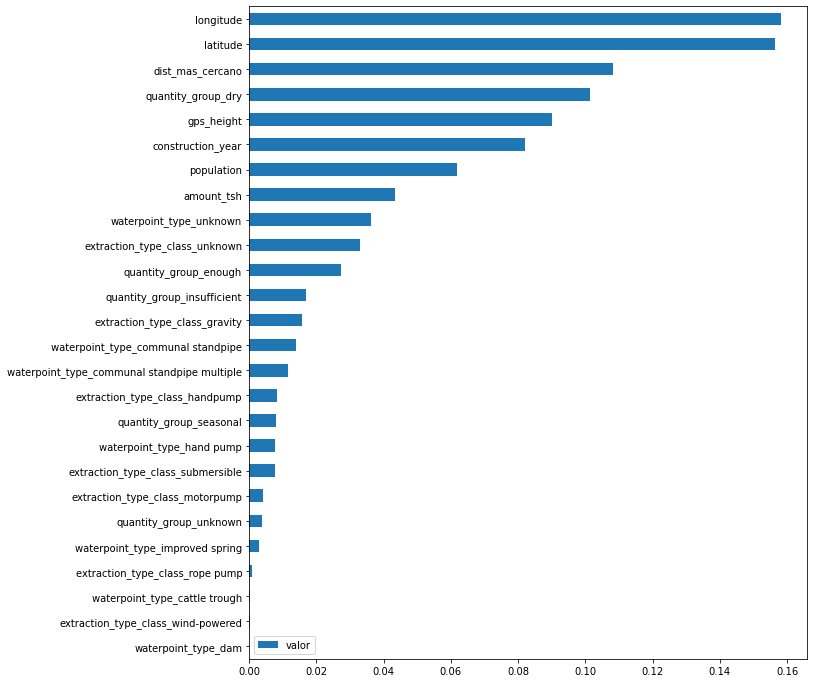

In [36]:
res_features=pd.DataFrame(index=df_train_three.columns.to_list()[:-2],data=pipelines[indice_mejor.values[0]].best_estimator_.named_steps["classifier"].feature_importances_.tolist(),columns=['valor']).sort_values(by='valor',ascending=True)
res_features.plot.barh(figsize=[10,12])